In [2]:

import numpy as np
import os
import random
import cv2
import json

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Convolution2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

from  matplotlib import pyplot as plt
import matplotlib.image as mpimg

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay



In [ ]:
#Configure GPU 
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [4]:
# Constants

TRAIN_1 = 'train_1'
TRAIN_2 = 'train_2'
TEST = 'test'

IMG_WIDTH=96
IMG_HEIGHT=96

CLASS_DICT = {'junk': 0, 
              'cup': 1, 
              'bowl': 2, 
              'decorative': 3}

CLASS_KEY = {0:'junk',
             1:'cup',
             2:'bowl',
             3:'decorative'}

# Random visual sampling of classes

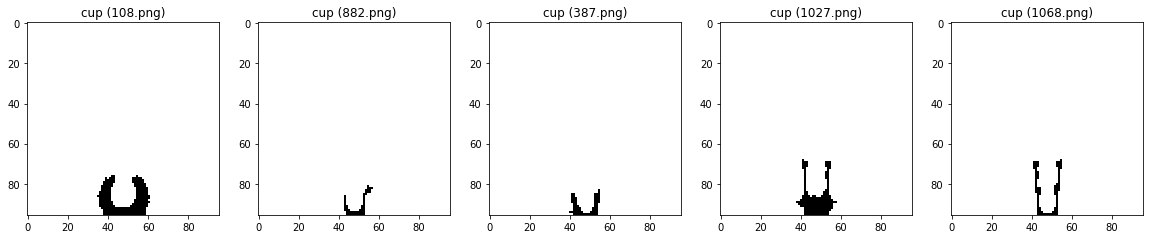

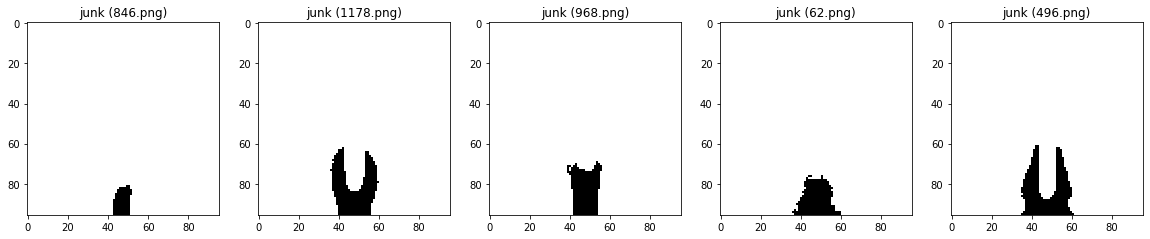

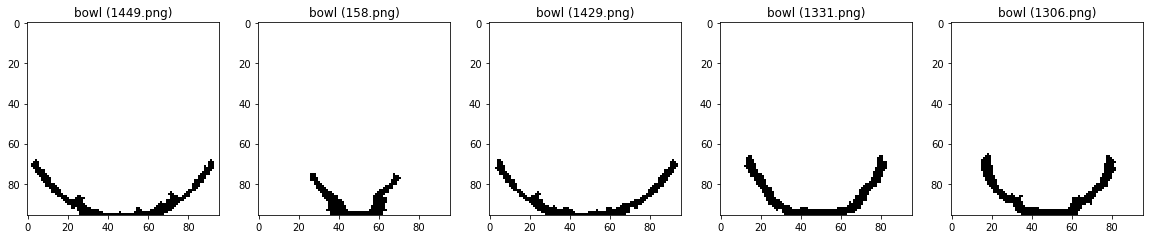

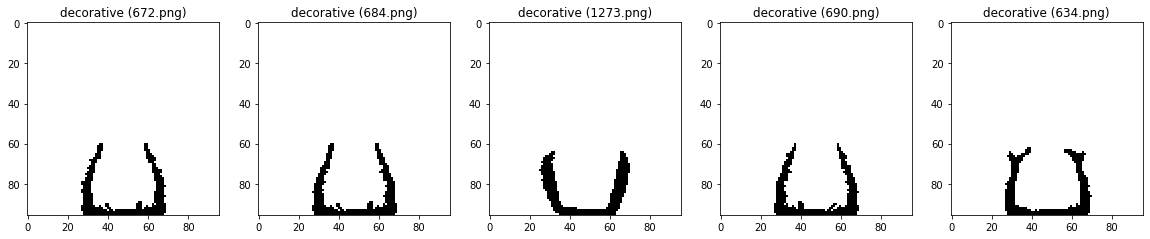

In [5]:
def display_class_samples(root_dir):
    for folder in os.listdir(root_dir):  
        folder_path = os.path.join(root_dir, folder)
        if os.path.isdir(folder_path):
            
            plt.figure(figsize=(20,20))
            for i in range(5):
                file = random.choice(os.listdir(folder_path))
                image_path= os.path.join(folder_path, file)
                img=mpimg.imread(image_path)
                ax=plt.subplot(1,5,i+1)
                ax.title.set_text(f'{folder} ({file})')
                plt.imshow(img,interpolation='nearest')

display_class_samples(TEST)

# Helper functions

In [6]:
def create_dataset(img_folder, random_seed=42):
    img_data_array=[]
    class_name=[]
   
    for directory in os.listdir(img_folder):
        if os.path.isdir(os.path.join(img_folder, directory)):
            
            for file in os.listdir(os.path.join(img_folder, directory)):
            
                image_path= os.path.join(img_folder, directory,  file)
                image= cv2.imread( image_path, cv2.IMREAD_GRAYSCALE)
                image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
                image=np.array(image)
                image = image.astype('float32')
                image /= 255 
                img_data_array.append(image)
                class_name.append(CLASS_DICT[directory])
                
    
    return shuffle(np.array(img_data_array), np.array(class_name), random_state=random_seed)


In [7]:
def save_weights_and_biases(model, file):
    json_string = []
    for i in range(len(model.layers)):
        weights_biases = []
        for k in range(len(model.layers[i].get_weights())):
            weights_biases.append(model.layers[i].get_weights()[k].tolist())
        json_string.append({'config': model.layers[i].get_config(), 'weights_biases': weights_biases})

    with open(f'{file}.json', 'w', encoding='utf-8') as f:
        json.dump(json_string, f, ensure_ascii=False, indent=3)

In [8]:
def display_false_classifications(true, predict, images, limit=50):
        displayed = 0
        
        for i in range(len(true)):
                if displayed >= limit: return
                if true[i] != predict[i]:
                        displayed+=1
                        plt.imshow(images[i],interpolation='nearest',cmap='Greys_r')
                        plt.title(f'TRUE: {CLASS_KEY[true[i]]} | PREDICT: {CLASS_KEY[predict[i]]}')
                        plt.show()

In [9]:
def display_confusion_matrix(true, predict):
    cm = confusion_matrix(true, predict)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['junk','cup','bowl','decorative']
                              )
    disp.plot()

    plt.show()

In [10]:
def create_model(seed):
    tf.random.set_seed(seed)

    classifier = Sequential()

    classifier.add(Convolution2D(filters=5, kernel_size=2, activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(IMG_HEIGHT,IMG_WIDTH, 1)))
    classifier.add(MaxPooling2D((2, 2)))
    classifier.add(Flatten())
    classifier.add(Dense(8, activation='relu', kernel_initializer='he_uniform'))
    classifier.add(Dense(4, activation='softmax'))

    classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return classifier
    

# model_1

In [12]:
## Train: train_1 | Test: test

X_train_data, y_train_data = create_dataset(TRAIN_1)
X_test_data, y_test_data = create_dataset(TEST)

# Reshape train data into tensor form, save original form for comparison
X_train = X_train_data.reshape(X_train_data.shape[0],IMG_HEIGHT,IMG_WIDTH, 1)
X_test = X_test_data.reshape(X_test_data.shape[0],IMG_HEIGHT,IMG_WIDTH, 1)
# Reshape test data into categorical form
y_train = to_categorical(y_train_data)
y_test = to_categorical(y_test_data)

In [14]:
classifier = create_model(80)
classifier.fit(x=X_train, 
                         y=y_train, 
                         batch_size=10,
                         epochs=3, 
                         verbose=1,
                         validation_data=(X_test,y_test)
                        )   

2022-01-24 16:04:26.664531: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 249716736 exceeds 10% of free system memory.


Epoch 1/3
678/678 [==============================] - 2s 3ms/step - loss: 0.8812 - accuracy: 0.6357 - val_loss: 0.4009 - val_accuracy: 0.8367
Epoch 2/3
678/678 [==============================] - 2s 3ms/step - loss: 0.2594 - accuracy: 0.9115 - val_loss: 0.4061 - val_accuracy: 0.8387
Epoch 3/3
678/678 [==============================] - 2s 3ms/step - loss: 0.1813 - accuracy: 0.9345 - val_loss: 0.4463 - val_accuracy: 0.8354


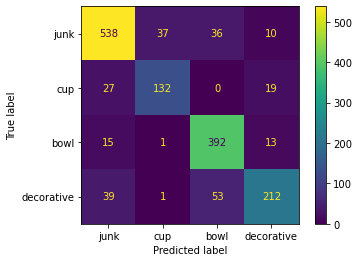

In [31]:
predictions = np.argmax(classifier.predict(X_test), axis=-1)
display_confusion_matrix(y_test_data, predictions)


In [34]:
save_weights_and_biases(classifier, 'model_1')

In [ ]:
display_false_classifications(y_test_data, predictions, X_test)

# model_2

In [32]:
## Train: train_2 | Test: test

X_train_data, y_train_data = create_dataset(TRAIN_2)
X_test_data, y_test_data = create_dataset(TEST)

# Reshape train data into tensor form, save original form for comparison
X_train = X_train_data.reshape(X_train_data.shape[0],IMG_HEIGHT,IMG_WIDTH, 1)
X_test = X_test_data.reshape(X_test_data.shape[0],IMG_HEIGHT,IMG_WIDTH, 1)
# Reshape test data into categorical form
y_train = to_categorical(y_train_data)
y_test = to_categorical(y_test_data)

In [33]:
classifier = create_model(1234512345345)
classifier.fit( x=X_train, 
                y=y_train, 
                batch_size=10,
                epochs=4, 
                verbose=1,
                validation_data=(X_test,y_test)
              )   

2022-01-24 16:11:41.456429: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 189997056 exceeds 10% of free system memory.


Epoch 1/4
500/516 [============================>.] - ETA: 0s - loss: 0.6428 - accuracy: 0.7802

2022-01-24 16:11:43.163384: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 56217600 exceeds 10% of free system memory.


516/516 [==============================] - 2s 3ms/step - loss: 0.6339 - accuracy: 0.7835 - val_loss: 0.5649 - val_accuracy: 0.8407
Epoch 2/4
516/516 [==============================] - 2s 3ms/step - loss: 0.1456 - accuracy: 0.9537 - val_loss: 0.6678 - val_accuracy: 0.8348
Epoch 3/4
516/516 [==============================] - 2s 3ms/step - loss: 0.1016 - accuracy: 0.9681 - val_loss: 0.6049 - val_accuracy: 0.8420
Epoch 4/4
516/516 [==============================] - 2s 3ms/step - loss: 0.0792 - accuracy: 0.9724 - val_loss: 0.6078 - val_accuracy: 0.8420


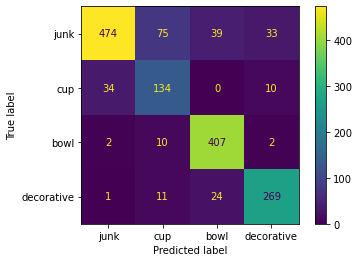

In [35]:
predictions = np.argmax(classifier.predict(X_test), axis=-1)
display_confusion_matrix(y_test_data, predictions)

In [88]:
save_weights_and_biases(classifier, 'model_2')

In [ ]:
display_false_classifications(y_test_data, predictions, X_test)

# model_3

In [36]:
## Train: train_1 + train_2 | Test: test

X_1, y_1 = create_dataset(TRAIN_1)
X_2, y_2 = create_dataset(TRAIN_2)

X_train_data = np.concatenate((X_1, X_2))
y_train_data = np.concatenate((y_1, y_2))

shuffle(X_train_data, y_train_data, random_state=42)

X_test_data, y_test_data = create_dataset(TEST)

# Reshape train data into tensor form
X_train = X_train_data.reshape(X_train_data.shape[0],IMG_HEIGHT,IMG_WIDTH, 1)
X_test = X_test_data.reshape(X_test_data.shape[0],IMG_HEIGHT,IMG_WIDTH, 1)
# Reshape test data into categorical form
y_train = to_categorical(y_train_data)
y_test = to_categorical(y_test_data)

In [37]:
classifier = create_model(1234512345345)
classifier.fit(x=X_train, 
                         y=y_train, 
                         batch_size=10,
                         epochs=10, 
                         verbose=1,
                         validation_data=(X_test,y_test)
                        )   

Epoch 1/10
1193/1193 [==============================] - 4s 3ms/step - loss: 0.5361 - accuracy: 0.8077 - val_loss: 0.5013 - val_accuracy: 0.8275
Epoch 2/10
1193/1193 [==============================] - 3s 3ms/step - loss: 0.1611 - accuracy: 0.9445 - val_loss: 0.4635 - val_accuracy: 0.8466
Epoch 3/10
1193/1193 [==============================] - 4s 3ms/step - loss: 0.1226 - accuracy: 0.9561 - val_loss: 0.4718 - val_accuracy: 0.8590
Epoch 4/10
1193/1193 [==============================] - 3s 3ms/step - loss: 0.0873 - accuracy: 0.9718 - val_loss: 0.5724 - val_accuracy: 0.8446
Epoch 5/10
1193/1193 [==============================] - 4s 3ms/step - loss: 0.0762 - accuracy: 0.9758 - val_loss: 0.6162 - val_accuracy: 0.8518
Epoch 6/10
1193/1193 [==============================] - 4s 3ms/step - loss: 0.0684 - accuracy: 0.9730 - val_loss: 0.5830 - val_accuracy: 0.8485
Epoch 7/10
1193/1193 [==============================] - 4s 3ms/step - loss: 0.0483 - accuracy: 0.9863 - val_loss: 0.7374 - val_accuracy:

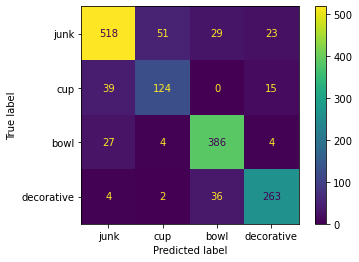

In [39]:
predictions = np.argmax(classifier.predict(X_test), axis=-1)
display_confusion_matrix(y_test_data, predictions)

In [14]:
save_weights_and_biases(classifier, 'model_3')

In [ ]:
display_false_classifications(y_test_data, predictions, X_test)

# model_4

In [17]:
## Train: train_1 + test | Test: train_1

X_1, y_1 = create_dataset(TRAIN_1)
X_2, y_2 = create_dataset(TEST)

X_train_data = np.concatenate((X_1, X_2))
y_train_data = np.concatenate((y_1, y_2))

shuffle(X_train_data, y_train_data, random_state=42)

X_test_data, y_test_data = create_dataset(TRAIN_2)
# Reshape train data into tensor form
X_train = X_train_data.reshape(X_train_data.shape[0],IMG_HEIGHT,IMG_WIDTH, 1)
X_test = X_test_data.reshape(X_test_data.shape[0],IMG_HEIGHT,IMG_WIDTH, 1)
# Reshape test data into categorical form
y_train = to_categorical(y_train_data)
y_test = to_categorical(y_test_data)

In [18]:
classifier = create_model(2345367536)
classifier.fit( x=X_train, 
                y=y_train, 
                batch_size=10,
                epochs=2, 
                verbose=1,
                validation_data=(X_test,y_test)
                )

Epoch 1/2
830/830 [==============================] - 4s 4ms/step - loss: 0.6281 - accuracy: 0.7632 - val_loss: 0.6731 - val_accuracy: 0.7848
Epoch 2/2
830/830 [==============================] - 3s 4ms/step - loss: 0.1834 - accuracy: 0.9332 - val_loss: 0.8638 - val_accuracy: 0.7516


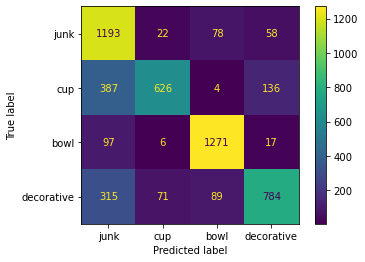

In [19]:
predictions = np.argmax(classifier.predict(X_test), axis=-1)
display_confusion_matrix(y_test_data, predictions)


In [29]:
save_weights_and_biases(classifier, 'model_4')

In [ ]:
display_false_classifications(y_test_data, predictions, X_test)


In [11]:
## Train: train_2 + test | Test: train_2

X_1, y_1 = create_dataset(TRAIN_2)
X_2, y_2 = create_dataset(TEST)

X_train_data = np.concatenate((X_1, X_2))
y_train_data = np.concatenate((y_1, y_2))

shuffle(X_train_data, y_train_data, random_state=42)

X_test_data, y_test_data = create_dataset(TRAIN_1)
# Reshape train data into tensor form
X_train = X_train_data.reshape(X_train_data.shape[0],IMG_HEIGHT,IMG_WIDTH, 1)
X_test = X_test_data.reshape(X_test_data.shape[0],IMG_HEIGHT,IMG_WIDTH, 1)
# Reshape test data into categorical form
y_train = to_categorical(y_train_data)
y_test = to_categorical(y_test_data)

In [13]:
classifier = create_model(3)
classifier.fit( x=X_train, 
                y=y_train, 
                batch_size=10,
                epochs=4, 
                verbose=1,
                validation_data=(X_test,y_test)
                )

2022-01-24 16:31:16.325134: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 246214656 exceeds 10% of free system memory.


Epoch 1/4
654/668 [============================>.] - ETA: 0s - loss: 0.7432 - accuracy: 0.7202

2022-01-24 16:31:18.559009: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 249716736 exceeds 10% of free system memory.


668/668 [==============================] - 3s 5ms/step - loss: 0.7369 - accuracy: 0.7229 - val_loss: 0.8764 - val_accuracy: 0.7719
Epoch 2/4
668/668 [==============================] - 3s 5ms/step - loss: 0.1895 - accuracy: 0.9384 - val_loss: 1.0227 - val_accuracy: 0.7749
Epoch 3/4
668/668 [==============================] - 3s 4ms/step - loss: 0.1313 - accuracy: 0.9569 - val_loss: 1.1658 - val_accuracy: 0.7759
Epoch 4/4
668/668 [==============================] - 3s 4ms/step - loss: 0.1031 - accuracy: 0.9625 - val_loss: 1.3134 - val_accuracy: 0.7746


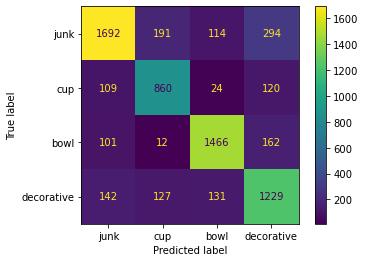

In [15]:
predictions = np.argmax(classifier.predict(X_test), axis=-1)
display_confusion_matrix(y_test_data, predictions)

In [61]:
save_weights_and_biases(classifier, 'model_5')

In [ ]:
display_false_classifications(y_test_data, predictions, X_test)